In [1]:
import pandas as pd 
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from nltk.corpus import stopwords
from nltk import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import string
import matplotlib.pyplot as plt;
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import pandas as pd
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt, seaborn as sns, folium
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
import datetime

In [6]:
sns.set(style = 'ticks') # 'darkgrid')
palette = {'negative': 'sandybrown', 'neutral': 'lightskyblue', 'positive': 'darkblue'} #

In [9]:
df= pd.read_csv('/Users/stephenkim/Desktop/yeji/NLP/Tweets.csv')

In [4]:
df.shape

(14640, 15)

In [5]:
df.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,NaN,Pacific Time (US & Canada)


In [206]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791092e+14,0.162830,0.330440,0.745778
min,5.675880e+17,0.335000,0.000000,0.000000
25%,5.685590e+17,0.692300,0.360600,0.000000
50%,5.694780e+17,1.000000,0.670600,0.000000
75%,5.698902e+17,1.000000,1.000000,0.000000
max,5.703110e+17,1.000000,1.000000,44.000000


In [309]:


pd.set_option('display.max_colwidth', -1)



In [310]:
df1 = df[['text', 'airline_sentiment']].copy()
df1.sample(5)

,text,airline_sentiment
10683,"@usairways now on hold for an hour. So frustrating, I suspect you have more operators come in on days like this w/inclement weather?",negative
9611,@usairways Why are we waiting 40 min so far for our luggage??? #wannagohome,negative
9739,"@USAirways worst service at Reagan Int. I rarely post about a company or service, but I am so annoyed. Not weather reLate Flightd…incompetence.",negative
12298,"@AmericanAir I can DM it to you, if you follow me",neutral
1603,"@united Late Flight 2014 and 2015 are huge step towards decline in service, and your agents, not all, are as arrogant as ever. #UnitedAirlines",negative


# Data Analysis 

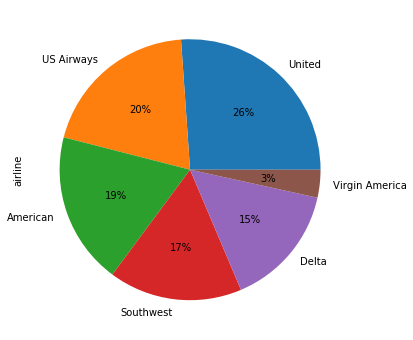

In [77]:
df.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

Distribution of sentiments across all the tweets

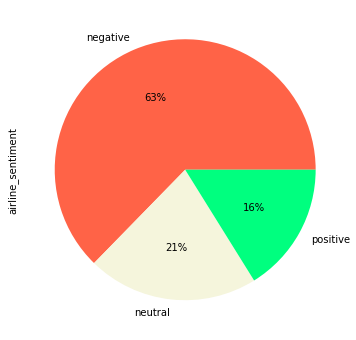

In [87]:
df.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["tomato", "beige", "springgreen"])

# JUNE 5

### NEGATIVE REASONS

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64


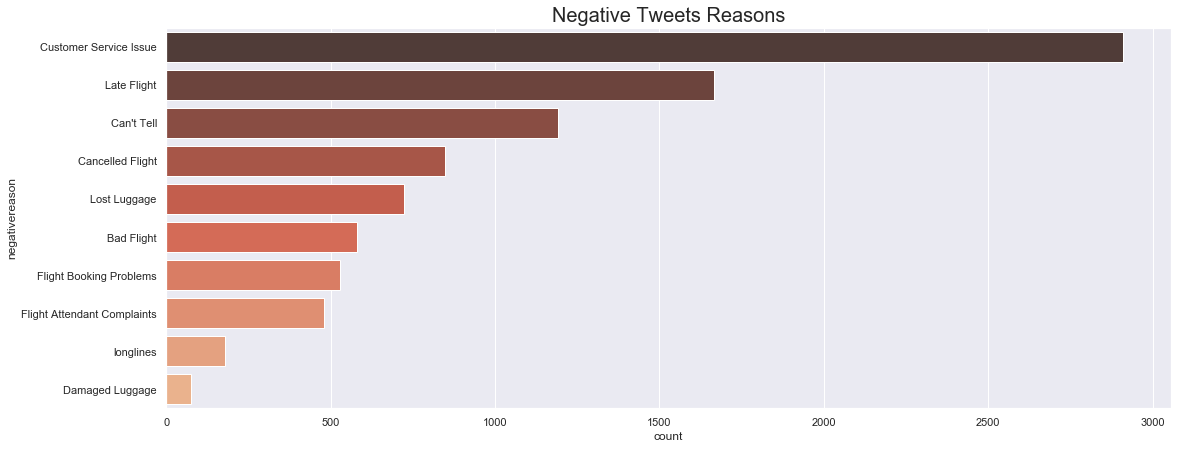

In [90]:
print(df.negativereason.value_counts())
fig = plt.figure(figsize=(18, 7))
ax0 = sns.countplot(y = 'negativereason', data = df, order = df.negativereason.value_counts().index, palette="OrRd_d")
ax0.set_title('Negative Tweets Reasons', fontsize=20)

fig.savefig('demo3.png', transparent=True)

### sentiment % by airline

In [115]:
air_sen=pd.crosstab(df.airline, df.airline_sentiment)
#air_sen.sort_values('airline_sentiment', ascending=True)

air_sen.sort_index(ascending=True)

#air_sen

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


In [103]:
percentage=air_sen.apply(lambda a: a / a.sum() * 100, axis=1)
percentage

airline_sentiment,negative,neutral,positive
airline,,,
American,71.040232,16.781443,12.178325
Delta,42.979298,32.538254,24.482448
Southwest,49.008264,27.438017,23.553719
US Airways,77.686234,13.079300,9.234466
United,68.890633,18.236525,12.872841
Virgin America,35.912698,33.928571,30.158730


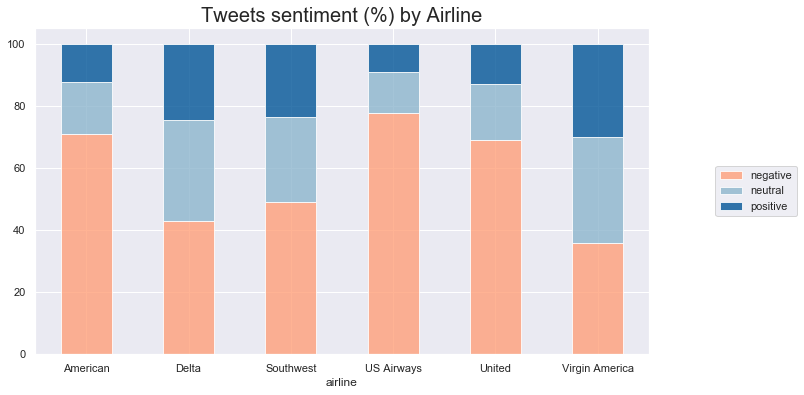

In [153]:
palette = ["#ffa07a", "#8db6cd", "#015597"]
#color=sns.color_palette("coolwarm_d", 3)
p = percentage.plot(kind='bar',figsize=(11, 6),alpha=0.8, color=palette,
                rot=0,stacked=True)

#axes.set_title("Airline Sentiment Proportion",fontsize=20)

p.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
p.set_title('Tweets sentiment (%) by Airline', fontsize=20)
#p.ylabel('Tweets(%)', fontsize=15)
#plt.show()
plt.savefig('demo45.png', transparent=True)



## NEGATIVE BY TIME (HR)

In [183]:
df['tweet_created'] = pd.to_datetime(df.tweet_created)

In [184]:
df['tweet_created_hour'] = df.tweet_created.dt.hour
pf = df.groupby(['tweet_created_hour']).negativereason.value_counts()
pf.unstack()

negativereason,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines
tweet_created_hour,,,,,,,,,,
0,10.0,14.0,11.0,27.0,NaN,4.0,2.0,13.0,15.0,1.0
1,3.0,15.0,3.0,29.0,3.0,3.0,3.0,7.0,13.0,1.0
2,3.0,11.0,7.0,46.0,NaN,11.0,3.0,11.0,14.0,3.0
3,10.0,17.0,17.0,51.0,1.0,3.0,5.0,21.0,17.0,4.0
4,15.0,33.0,20.0,74.0,2.0,18.0,13.0,38.0,21.0,2.0
5,20.0,32.0,33.0,108.0,2.0,16.0,18.0,61.0,20.0,3.0
6,34.0,54.0,36.0,138.0,1.0,20.0,16.0,63.0,25.0,8.0
7,21.0,56.0,51.0,168.0,2.0,24.0,28.0,88.0,28.0,9.0
8,40.0,59.0,50.0,206.0,2.0,22.0,34.0,102.0,30.0,11.0


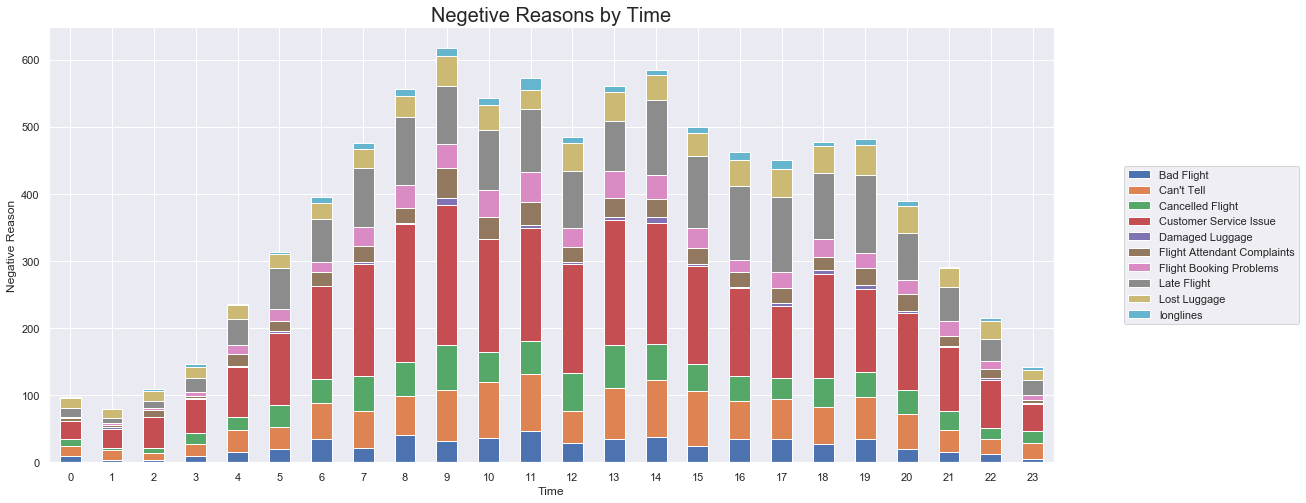

In [188]:
my_plot = pf.unstack().plot(kind='bar',stacked=True,figsize=(18, 8),rot=0)

my_plot.set_title("Negetive Reasons by Time", fontsize=20)
my_plot.set_xlabel("Time")
my_plot.set_ylabel("Negative Reason")
my_plot.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.savefig('demo46.png', transparent=True)

### LOCATION

In [10]:
v1 = df['tweet_coord'].notna()
df1 = pd.DataFrame()
df1[['lat', 'lon']] = pd.DataFrame(df['tweet_coord'][v1].apply(lambda x: [pd.eval(x)[0], pd.eval(x)[1]]).values.tolist(), index = df.index[v1])
df= df.merge(df1, left_index = True, right_index = True, how = 'left', validate = '1:1') 
#df.join(df1, how = 'left')

for x in ['tweet_coord', 'tweet_location', 'user_timezone']:
    df[x+ '_f'] = 0
    df[x + '_f'][df[x].notna() & (df[x] != '[0.0, 0.0]')] = 1
    print(df[x + '_f'].value_counts())

0    13785
1      855
Name: tweet_coord_f, dtype: int64
1    9907
0    4733
Name: tweet_location_f, dtype: int64
1    9820
0    4820
Name: user_timezone_f, dtype: int64


/Users/stephenkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [240]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,lat,lon,tweet_coord_f,tweet_location_f,user_timezone_f
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,NaN,Eastern Time (US & Canada),NaN,NaN,0,0,1
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,NaN,Pacific Time (US & Canada),NaN,NaN,0,0,1
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,Lets Play,Central Time (US & Canada),NaN,NaN,0,1,1
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,NaN,Pacific Time (US & Canada),NaN,NaN,0,0,1
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,NaN,Pacific Time (US & Canada),NaN,NaN,0,0,1


In [11]:
df2 = df[['airline_sentiment', 'lat', 'lon', 'airline', 'text']][v1].round(decimals = 0)
df2['n'] = 1
df2['text'] = df2['airline'] + ' - ' + df2['text']
df2.drop(columns = 'airline', inplace = True)
df2 = df2.groupby(['airline_sentiment', 'lat', 'lon']).agg({'n': 'count', 'text': list}).reset_index()
df2['n'] = df2['n'].astype(float)


In [16]:
m = folium.Map(location = [20, 0], tiles = 'OpenStreetMap', zoom_start = 2.5) # 'Mapbox Bright', 'Mapbox Control Room'
for i in df2.index:
    folium.CircleMarker(
        location = [df2.loc[i, 'lat'], df2.loc[i, 'lon']],
        popup = df2.loc[i, 'text'],
        radius = df2.loc[i, 'n'],
        color = palette[df2.loc[i, 'airline_sentiment']],
        fill = True,
        fill_color = palette[df2.loc[i, 'airline_sentiment']]
    ).add_to(m)
m

In [17]:
m.save('plot_data.html')

### NEGATIVE TWEETS BY AIRLINE